# CS4487 - Machine Learning
# Lecture 7 - Linear Dimensionality Reduction
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Linear Dimensionality Reduction
    1. Principal Component Analysis (PCA)  
    2. Latent Semantica Analysis (LSA)
    3. Non-negative Matrix Factorization (NMF)
    4. Linear Discriminant Analysis (LDA)


In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Dimensionality Reduction
- **Goal:** Transform high-dimensional vectors into low-dimensional vectors.
  - Dimensions in the low-dim data represent co-occuring features in high-dim data.
  - Dimensions in the low-dim data may have semantic meaning.
- **For example:** document analysis
  - high-dim: bag-of-word vectors of documents
  - low-dim: each dimension represents similarity to a topic.
<img src="lecture6/topic.png" width=500px>

- **Example:** image analysis
  - approximate an image as a weighted combination of several basis images
  - represent the image as the weights.
<img src="lecture7/eigenfaces.jpg" width="800px">

# Reasons for Dimensionality Reduction
- Preprocessing - make the dataset easier to use
- Reduce computational cost of running machine learning algorithms
- Remove noise
- Make the results easier to understand (visualization)

# Linear Dimensionality Reduction
- Project the original data onto a lower-dimensional hyperplane (e.g., line, plane).
  - I.e, Move and rotate the coordinate axis of the data
<img src="lecture7/pca.png" width="800px">

- Equivalently, approximate the data point $x$ as a linear combination of basis vectors (components) in the original space.
  - original data point $x\in\mathbb{R}^d$
  - approximation: $\hat{x} = \sum_{j=1}^p w_j v_j$
    - $v_j\in\mathbb{R}^d$ is a basis vector and $w_j\in\mathbb{R}$ the corresponding weight.
  - the data point $x$ is then represented its corresponding weights
    - $w = [w_1,\cdots,w_P] \in \mathbb{R}^p$

- Several methods for linear dimensionality reduction.
- **Differences:**
  - goal (reconstruction vs classification)
  - unsupervised vs. supervised
  - constraints on the basis vectors and the weights.

# Principal Component Analysis (PCA)
- Unsupervised method
- **Goal:** preserve the variance of the data as much as possible
  - choose basis vectors along the maximum variance (longest extent) of the data.
  - the basis vectors are called _principal components_ (PC).

In [2]:
def plot_basis(X, vo, Xp=None, sp=None, showleg=True, Y=None):
    if sp == None:
        sp = ((1,2,1), (1,2,2))
    cols = ['k','g']
    
    if Y == None:
        Y = zeros(len(X))
        mycmap = plt.get_cmap('bwr')
    else:
        mycmap = rbow
    
    # normalize v
    v = vo.copy()
    numd = v.shape[0]
    for j in range(numd):
        v[j,:] /= linalg.norm(v[j,:])
        # flip direction if necessary
        if all(v[j,:] < 0):
            v[j,:] *= -1.0
        
    Xm = mean(X,axis=0)         # get mean
    if Xp==None:
        Xp = dot(X-Xm,v.T) # project data onto v
    
    plt.subplot(sp[0][0], sp[0][1], sp[0][2])
    # plot points
    plt.scatter(X[:,0], X[:,1], s=5, edgecolor="", c=Y, cmap=mycmap)

    plt.axis('equal'); plt.grid(True)
    plt.title('Original space (x)')
    
    tmp = plt.axis()
    hw = (tmp[1]-tmp[0])/30
    lw = hw/10
    
    mind = zeros(numd)
    maxd = zeros(numd)
    Ls = []
    LL = []
    for j in range(numd):
        mind[j] = Xp[:,j].min()
        maxd[j] = Xp[:,j].max()
        
        ofact = 0.9
        Xm2 = Xm + v[j]*maxd[j]*ofact
        Xm1 = Xm + v[j]*mind[j]*ofact
        vl = v[j]*(maxd[j]-mind[j])*ofact        

        tmp = plt.arrow(Xm1[0], Xm1[1], vl[0], vl[1], width=lw, head_width=hw, 
                        color=cols[j], length_includes_head=True)
        Ls.append(tmp)
        LL.append("PC " + str(j))

    plt.plot(Xm[0], Xm[1], 'ks')
    if showleg:
        tmp = plt.legend(Ls, LL, loc='lower right')
        tmp.get_frame().set_facecolor('white')
        
    plt.subplot(sp[1][0], sp[1][1], sp[1][2])
    plt.arrow(mind[0]*ofact, 0, (maxd[0]-mind[0])*ofact, 0, width=lw, head_width=hw, color=cols[0])
    if numd == 2:
        plt.arrow(0, mind[1]*ofact, 0, (maxd[1]-mind[1])*ofact, width=lw, head_width=hw, color=cols[1])        
        plt.scatter(Xp[:,0], Xp[:,1], s=10, marker='+', c=Y, cmap=mycmap)
        plt.xlabel('w1')
        plt.ylabel('w2')
    else:
        plt.scatter(Xp[:,0], zeros(len(Xp)), s=10, marker='+', c=Y, cmap=mycmap)
        plt.xlabel('w')

    plt.axis('equal'); plt.grid(True)
    plt.title('Low-dim space (w)')

In [3]:
# image showing blobs of dots and various directions of largest variance
random.seed(5230)
Xblob,Y = datasets.make_blobs(100,2,[[2,1]],cluster_std=1)
tmp = random.normal(size=(2,2))+3.5*eye(2)
Xblob = dot(Xblob,tmp)

vfig = plt.figure(figsize=(10,6))
plot_basis(Xblob, array([[1, 0.0]]), sp=((2,3,1), (2,3,4)), showleg=False)
plot_basis(Xblob, array([[1, 0.5]]), sp=((2,3,2), (2,3,5)), showleg=False)
plot_basis(Xblob, array([[1.0, 1.0]]), sp=((2,3,3), (2,3,6)), showleg=False)
plt.close()

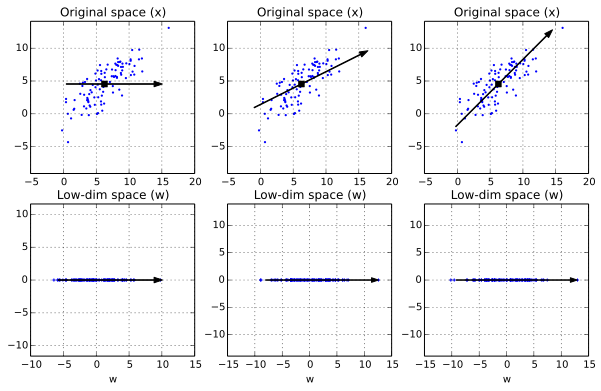

In [4]:
vfig

- **Goal:** Equivalently, minimize the reconstruction error over all the data points $\{x_i\}_{i=1}^N$.
  - reconstruction: $\hat{x_i} = \sum_{j=1}^p w_{i,j} v_j$
  $$\min_{w, v} \sum_{i=1}^N ||x_i - \hat{x}_i||^2$$
  - _constraint:_ principal components $v_j$ are orthogonal (perpendicular) to each other.
  

# PCA algorithm
- 1) subtract the mean of the data
- 2) the first PC $v_1$ is the direction that explains the most variance of the data.
- 3) the second PC $v_2$ is the direction perpendicular to $v_1$ that explains the most variance.
- 4) the third PC $v_3$ is the direction perpendicular to $\{v_1,v_2\}$ that explains the most variance.
- 5) ...


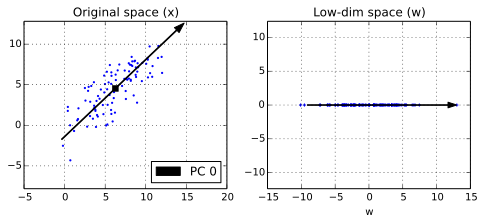

In [5]:
X = Xblob

# run PCA
pca = decomposition.PCA(n_components=1)
W   = pca.fit_transform(X)

v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean

plt.figure(figsize=(8,3))
plot_basis(X, v)

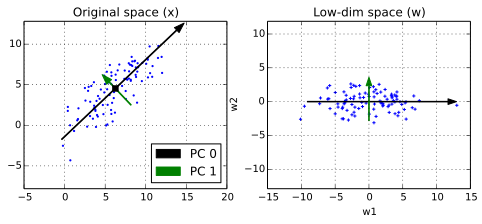

In [6]:
# run PCA
pca = decomposition.PCA(n_components=2)
W   = pca.fit_transform(X)

v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean

plt.figure(figsize=(8,3))
plot_basis(X, v)

# Example on Iris data
- 2D (petal length, sepal width) to 1D

In [7]:
# example on Iris
# define class labels, plot markers, and feature labels
featnames = ("petal length", "sepal width")
axbox = [0, 8, 1.5, 5]

rbow = plt.get_cmap('rainbow')

# load iris dataset from scikit-learn
iris = datasets.load_iris()    

# get data
Xiris = iris.data[:,(2,1)]
Yiris = iris.target
X = Xiris
Y = Yiris

pca = decomposition.PCA(n_components=1)
W = pca.fit_transform(X)

ifig = plt.figure(figsize=(8,3))
plot_basis(X, pca.components_)
plt.subplot(1,2,1)
plt.xlabel('petal length')
plt.ylabel('sepal width')
plt.close()

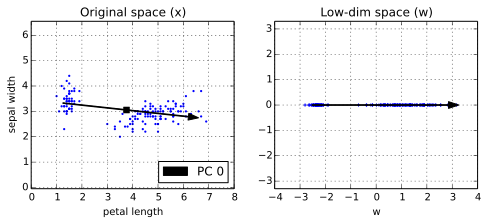

In [8]:
ifig

- 4D to 2D
- mostly preserves the structure of the classes.

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[ 0.36158968 -0.08226889  0.85657211  0.35884393]
 [-0.65653988 -0.72971237  0.1757674   0.07470647]]


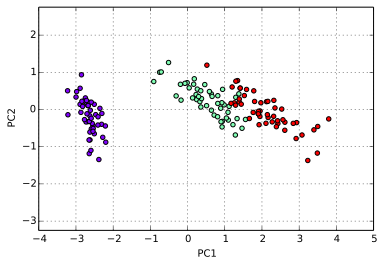

In [9]:
# get data
X = iris.data

# run PCA
pca = decomposition.PCA(n_components=2)
W = pca.fit_transform(X)

print iris.feature_names
print pca.components_

plt.figure
plt.scatter(W[:,0], W[:,1], c=Y, cmap=rbow)
plt.axis('equal'); plt.grid(True)
plt.xlabel('PC1'); plt.ylabel('PC2');

# How to choose the number of principal components?
- Two methods to set the number of components $p$:
  - preserve some percentage of the variance (e.g., 95%).
  - whatever works well for our final task (e.g., classification, regression).


# Handwritten digits data
- 1797 images of handwritten digits 0-9
  - each image is 8x8
  - flattened into a 64 dimensional vector

In [10]:
# get digit data
digits = datasets.load_digits()
Xdigits = float64(digits.data)
Ydigits = digits.target

print Xdigits.shape

(1797, 64)


In [11]:
# show examples
dfig = plt.figure(figsize=(8,3.5))
for j,n in enumerate(range(0,1797,190)):
    plt.subplot(2,5,j)
    I = Xdigits[n].reshape(8,8)
    plt.imshow(I, interpolation='nearest')
    plt.gray()
    plt.title(str(Ydigits[n]))
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
plt.close()

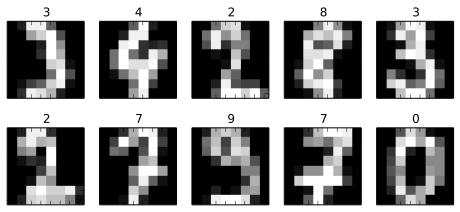

In [12]:
dfig

# Run PCA on the data
- split data into training and testing sets.
- run PCA on training set, apply to test set
- the top 25 PCs are shown

In [13]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  cross_validation.train_test_split(Xdigits, Ydigits, 
  train_size=0.5, test_size=0.5, random_state=4487)
Xdim = Xdigits.shape[1]

# run PCA
pca = decomposition.PCA()
W  = pca.fit_transform(trainX)  # fit the training set
Wt = pca.transform(testX)  # use the pca model to transform the test set

In [14]:
# plot the mean and the PCs
pcfig = plt.figure(figsize=(8,8))
plt.subplot(5,5,1)
plt.imshow(pca.mean_.reshape(8,8), interpolation='nearest')
plt.title("mean")
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])    
for j in range(0,24):
    plt.subplot(5,5,j+2)
    I = pca.components_[j,:].reshape(8,8)
    plt.imshow(I, interpolation='nearest')
    plt.gray()
    plt.title("PC " + str(j+1))
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
plt.close()

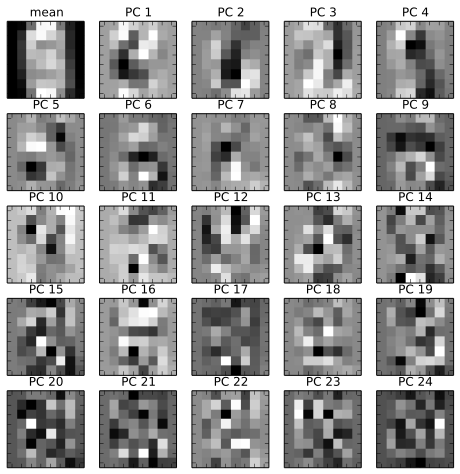

In [15]:
pcfig

# Explained variance
- each PC explains a percentage of the original data
  - this is called the _explained variance_.
  - PCs are already sorted by explained variance from highest to lowest
- pick the number of PCs to get a certain percentage of explained variance (e.g., 95%)

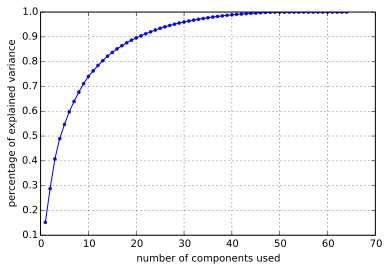

In [16]:
ev    = pca.explained_variance_ratio_  # variance explained by each component
cumev = cumsum(ev)                     # cumulative explained variance

plt.plot(range(1,Xdim+1), cumev, 'b.-')
plt.grid(True)
plt.xlabel('number of components used')
plt.ylabel('percentage of explained variance')

# Task-dependent Selection
- use results on the final task (in this case classification) to select the best number of components
- classification accuracy is stable after using 20 PCs.
  - not much loss in performance if using only 20 PCs.

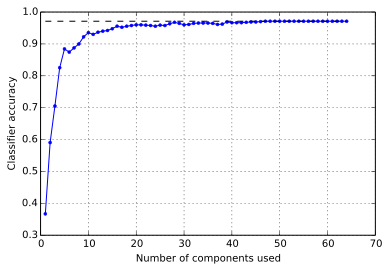

In [17]:
acc = zeros(Xdim)
for j in range(Xdim):
    # extract the subset of PC weights [0,j]
    Wnew     = W[:,0:(j+1)]
    Wnewtest = Wt[:,0:(j+1)]
    
    # train classifier
    clf = svm.SVC(kernel='linear', C=1)
    clf.fit(Wnew, trainY)

    # test classifier
    Ypred = clf.predict(Wnewtest)    
    acc[j] = mean(Ypred == testY)

# make a plot
plt.plot(range(1,Xdim+1), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('Number of components used')
plt.ylabel('Classifier accuracy')

# Latent Semantic Analysis (LSA)
- Also called _Latent Semantic Indexing_
- Consider a bag-of-word representation (e.g., TF, TF-IDF)
  - document vector $x_i$ 
  - $x_{i,j}$ is the frequency of word $j$ in document $i$

- Approximate each document vector as a weighted sum of topic vectors.
  - $\hat{x} = \sum_{n=1}^p w_p v_p$
  - Topic vector $v_p$ contains co-occuring high-frequency words.
    - corresponds to a particular _topic_ or _theme_.
  - Weight $w_p$ represents similarity of the document to the p-th topic.
- Objective: 
  - minimize the squared reconstruction error (Similar to PCA):
  - $\min_{v,w} \sum_i ||x_i - \hat{x}_i||^2$

- Represent each document by its topic weights.
  - Apply other machine learning algorithms...
- **Advantage:**   
  - Finds relations between terms (synonymy and polysemy).
  - distances/similarities are now comparing topics rather than words.

# Example on Spam Email dataset
- use bag-of-words representation with 50 words
- term-frequency (TF) normalization

In [18]:
# Load spam/ham text data from directories
textdata = datasets.load_files("lecture2/email", encoding="utf8", decode_error="replace")

# convert to bag-of-words representation
cntvect = feature_extraction.text.CountVectorizer(stop_words='english', max_features=50)
X = cntvect.fit_transform(textdata.data)
Y = textdata.target

# TF representation
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=False)
Xtf = tf_trans.fit_transform(X)

# print the vocabulary
print cntvect.vocabulary_

{u'buy': 14, u'cost': 18, u'mr': 34, u'address': 9, u'30': 5, u'today': 46, u'mg': 33, u'united': 47, u'answer': 10, u'inform': 27, u'office': 38, u'good': 23, u'day': 20, u'bank': 12, u'status': 44, u'pills': 43, u'isidoro': 29, u'number': 37, u'nigeria': 36, u'10': 2, u'john': 30, u'store': 45, u'contact': 17, u'online': 39, u'new': 35, u'visa': 48, u'120': 3, u'percocet': 41, u'00': 0, u'email': 21, u'60': 8, u'30mg': 6, u'15mg': 4, u'information': 28, u'country': 19, u'bags': 11, u'http': 26, u'000': 1, u'com': 16, u'codeine': 15, u'just': 31, u'50': 7, u'kamara': 32, u'peter': 42, u'google': 24, u'payment': 40, u'files': 22, u'hi': 25, u'watches': 49, u'brands': 13}


#LSA on Spam data
- Apply LSA (implemented as `TruncatedSVD`) with 5 topics

In [19]:
lsa = decomposition.TruncatedSVD(n_components=5, random_state=4487)
Wlsa = lsa.fit_transform(Xtf) 

# components
V = lsa.components_ 

In [20]:
def plot_topics(lsa, vocab):
    K = lsa.n_components
    Xr = arange(lsa.components_.shape[1])
    lsafig = plt.figure(figsize=(8,10))
    for j in range(K):
        plt.subplot(K,1,j+1)
        # get lsa component
        T = lsa.components_[j,:]    
        # get largest values
        tmp = argsort(abs(T))[-5:]

        plt.bar(Xr, T, color="")
        plt.plot(tmp+0.4, T[tmp], 'bo')
        # plot words on the top 5
        TW = []
        for q in tmp:
            mystr = vocab[q]
            if T[q]<0:
                mystr = "~" + mystr
            plt.annotate(xy=(q+0.4,T[q]), s=mystr, 
                         xytext=(q+0.4,T[q]), rotation=45, 
                         ha='left', va='bottom', color='red')
        plt.grid(True)
        plt.ylabel('Topic ' + str(j+1))
        if j == K-1:
            plt.xlabel('words')
    plt.close()
    
    return lsafig

#Topic vectors
- topic vectors contain frequent co-occuring words

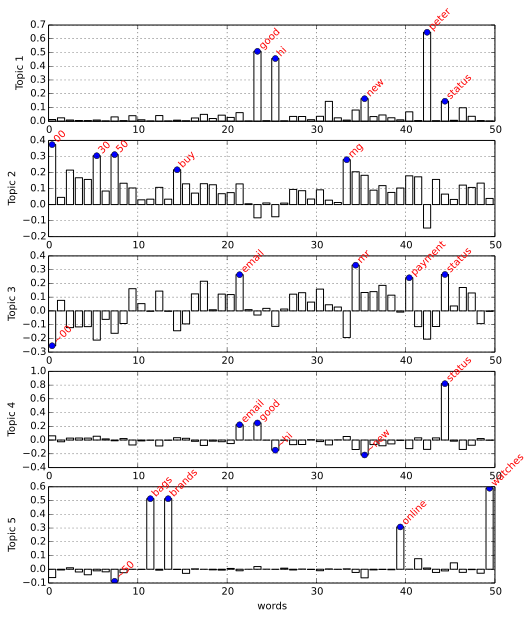

In [21]:
vocab = asarray(cntvect.get_feature_names())
lsafig = plot_topics(lsa, vocab)
lsafig

# Document representation
- Documents are a combination of topics

In [22]:
def plot_doc_topic(myXtf, myW, lsa, vocab):    
    docfig = plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    K  = lsa.n_components
    Xr = arange(lsa.components_.shape[1])
    myXtfa = myXtf.toarray().flatten()
    legL = []
    legS = []
    legL.append(plt.bar(Xr, myXtfa, lw=2, color=""))
    legS.append('document')
    plt.bar(Xr, myXtfa, lw=0, alpha=0.15, color='k')
    for j in range(K):
        T = lsa.components_[j,:]
        legL.append(plt.bar(Xr, myW[j]*T, color="", edgecolor=rbow(float(j)/K), lw=2))
        
        mystr = "Topic " + str(j+1)  \
                + " (w=% .4f"%(myW[j],) + ") "
               
        # get largest values, and add words
        tmp = argsort(abs(T))[-5:]
        for q in tmp:
            if T[q]<0:
                mystr += "~"
            mystr += vocab[q] + " "
        legS.append(mystr)
    plt.grid(True); plt.xlabel('words')
    tmpax = plt.axis()
    plt.axis([tmpax[0], tmpax[1], tmpax[2], 1.0])
    leg = plt.legend(legL, legS, fontsize=8, loc='upper center')
    leg.get_frame().set_facecolor('white')

    plt.subplot(2,1,2)
    legL = []
    legS = []
    legL.append(plt.bar(Xr, myXtfa, lw=2, color=""))
    legS.append('original document')
    plt.bar(Xr, myXtfa, lw=0, alpha=0.15, color='k')
    newX = dot(myW[newaxis,:],lsa.components_).flatten()
    legL.append(plt.bar(Xr, newX, color="", edgecolor='r', lw=1))
    legS.append('reconstruction')
    
    # get largest values
    cols = ('black', 'red')
    for i,T in enumerate([myXtfa, newX]):
        if i==0:
            tmp = where(abs(T)>=0.1)[0]
        else:
            tmp = where((abs(T)>=0.1) & (abs(myXtfa)<0.1))[0]
        #plt.plot(tmp+0.4, T[tmp], 'ko')
        for q in tmp:
            mystr = vocab[q]
            if T[q]<0:
                mystr = "~" + mystr
            plt.annotate(xy=(q+0.4,T[q]), s=mystr, 
                         xytext=(q+0.4,T[q]), rotation=45, 
                         ha='left', va='bottom', color=cols[i])
            
    plt.grid(True)
    plt.xlabel('words')
    plt.axis([tmpax[0], tmpax[1], tmpax[2], 1.0])
    leg = plt.legend(legL, legS, fontsize=8, loc='upper center')
    leg.get_frame().set_facecolor('white')
    plt.close()
    return docfig

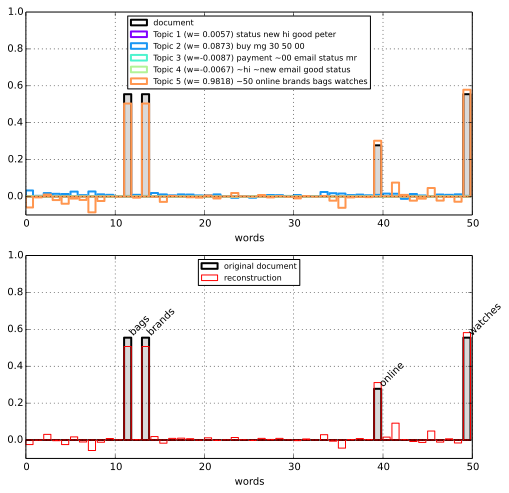

In [23]:
# Email 0
plot_doc_topic(Xtf[0,:], Wlsa[0,:], lsa, vocab)

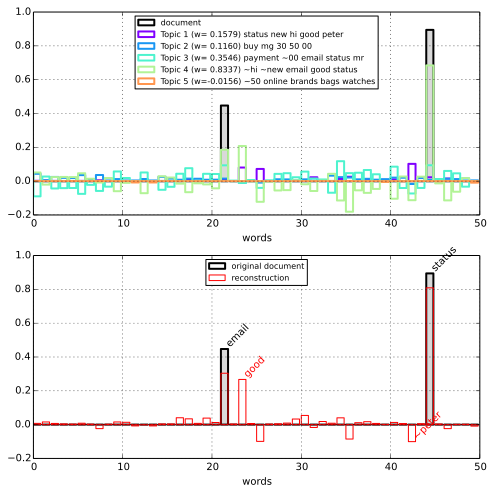

In [24]:
plot_doc_topic(Xtf[4,:], Wlsa[4,:], lsa, vocab)

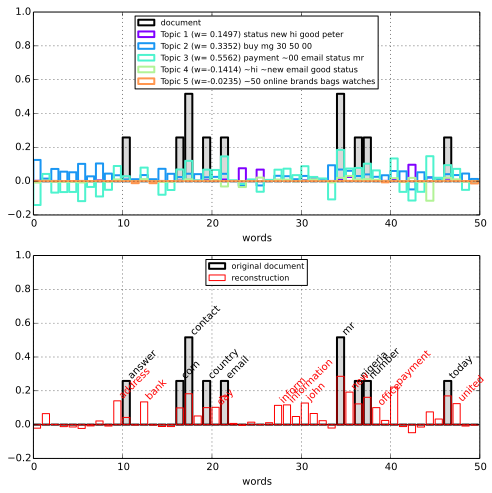

In [25]:
plot_doc_topic(Xtf[3,:], Wlsa[3,:], lsa, vocab)

# Problem with LSA
- In the topic vector, the "frequency" of a word can be negative!
  - Doesn't really make sense for document bag-of-words model.

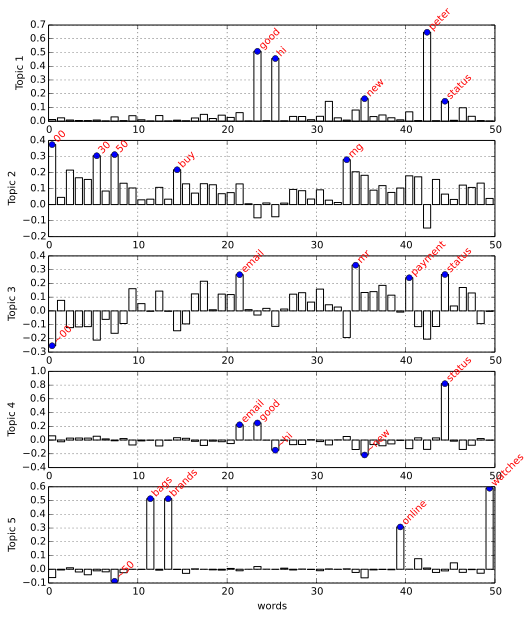

In [26]:
lsafig

# Problems with LSA
- The weights for each topic can be negative!
  - Topics should only be "additive"
    - Topics should increase probability of some topic-related words, but not decrease probability of other words.
    - It doesn't make sense to "remove" a topic using a negative topic weight.

In [27]:
pfig = plt.figure(figsize=(9,3))
for i,e in enumerate([0, 3, 7, 16]):
    plt.subplot(1,4,i+1)
    plt.bar(range(5), Wlsa[e,:])
    plt.title('Email ' + str(e))
    if i==0:
        plt.ylabel('LSA weights')
    plt.grid(True)
    plt.axis([0,5,-0.3,1])
plt.close()

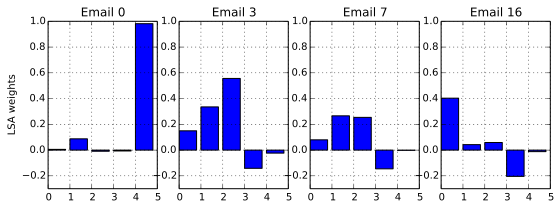

In [28]:
pfig

# Non-negative Matrix Factorization (NMF)
- **Solution:** constrain the topic vector and weights to be non-negative.
- Similar to LSA
  - Approximate each document vector as a weighted sum of topic vectors.
    - $\hat{x}_j = \sum_{n=1}^p w_p v_p$
    - But now, each entry of topic vector $v_p\geq 0$ and topic weight $w_p\geq 0$
  - Objective: minimize the squared reconstruction error
    - $\min_{v,w} \sum_j ||x_j - \hat{x}_j||^2$

In [29]:
# Run NMF
nmf = decomposition.NMF(n_components=5)
Wnmf = nmf.fit_transform(Xtf) 

# components
V = nmf.components_ 

# Topic vector
- all non-negative entries

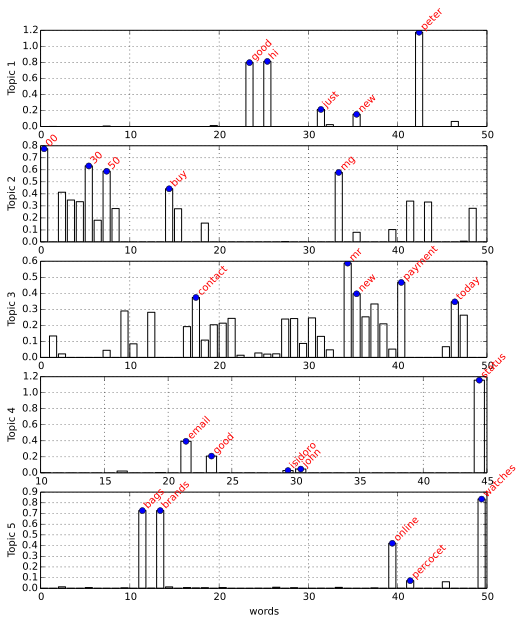

In [30]:
vocab = asarray(cntvect.get_feature_names())
plot_topics(nmf, vocab)

# Document vector
- additive combination of topics

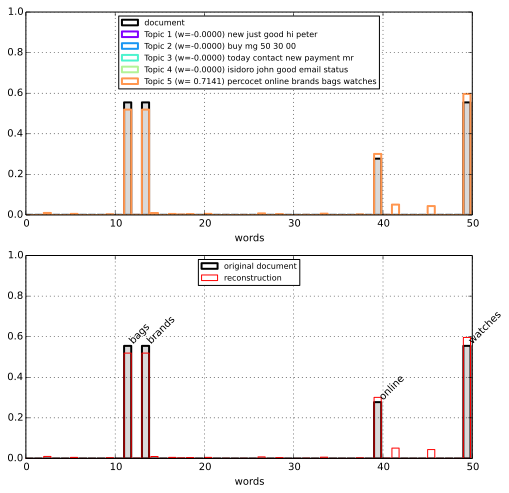

In [44]:
plot_doc_topic(Xtf[0,:], Wnmf[0,:], nmf, vocab)

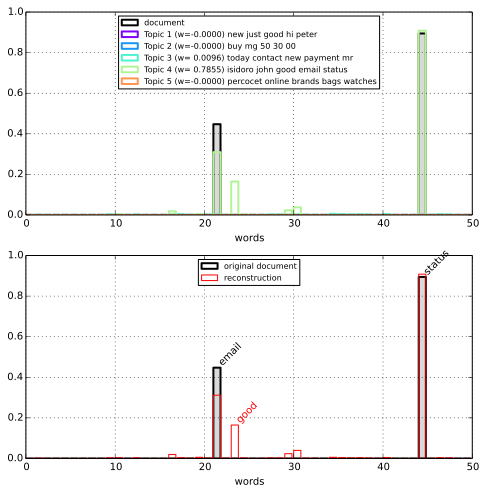

In [45]:
plot_doc_topic(Xtf[4,:], Wnmf[4,:], nmf, vocab)

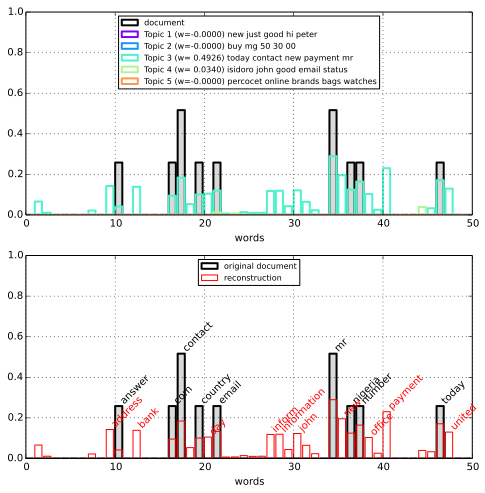

In [46]:
plot_doc_topic(Xtf[3,:], Wnmf[3,:], nmf, vocab)

# Sparseness
- For NMF representation, most topic weights for a document are zero.
  - this is called a _sparse_ representation.
  - each document is only composed of a few topics.

In [34]:
spfig = plt.figure(figsize=(9,5))
for i,e in enumerate([0, 3, 7, 16]):
    plt.subplot(2,4,i+1)
    plt.bar(range(5), Wlsa[e,:])
    plt.title('Email ' + str(e))
    if i==0:
        plt.ylabel('LSA weights')
    plt.grid(True)
    plt.axis([0,5,-0.3,1])
    plt.subplot(2,4,i+1+4)
    plt.bar(range(5), Wnmf[e,:])
    plt.axis([0,5,-0.3,1])
    if i==0:
        plt.ylabel('NMF weights')
    plt.grid(True)
plt.close()

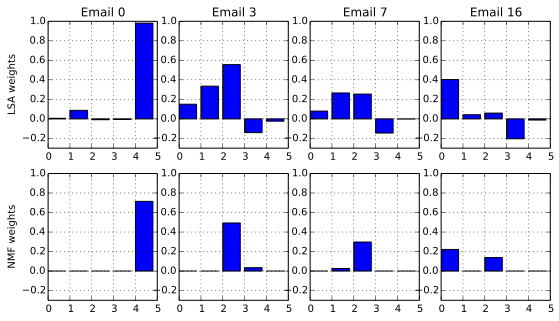

In [35]:
spfig

# Question
- Suppose we have data for the below classification problem...
- We want to reduce the data to 1 dimension using PCA.
  - What is the first PC?

In [36]:
# example of PCA problem
random.seed(38)
Xbars,Ybars = datasets.make_blobs(300,2,[[-5,0], [5,0]], cluster_std=0.8)
Xbars[:,0] /=8

X = Xbars
Y = Ybars

efig = plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1], c=Y, cmap=rbow, s=5, edgecolor="")
plt.axis('equal'); plt.grid(True)
plt.close()

e2fig = plt.figure(figsize=(8,4))
pca = decomposition.PCA(n_components=1)
W = pca.fit_transform(X)
plot_basis(X, pca.components_, Y=Y)
plt.close()

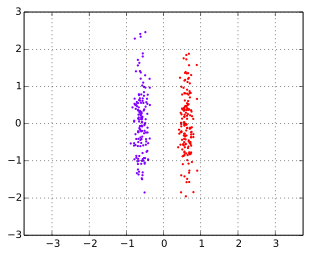

In [37]:
efig

# Answer
- first PC is along the direction of most variance.
  - collapses the two classes together!

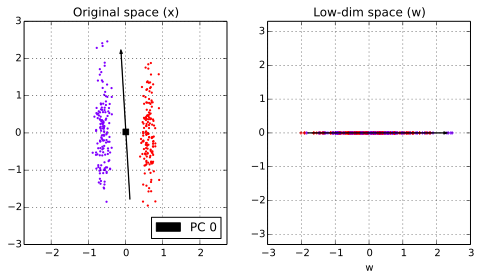

In [38]:
e2fig

# Problem with Unsupervised Methods
- If our end goal is classification, preserving the variance sometimes won't help!
  - PCA doesn't consider which class the data belongs to.
  - When the "classification" signal is less than the "noise", PCA will make classification more difficult.

# Linear Discriminant Analysis
- Supervised dimensionality reduction
- **Goal:** find a lower-dim space so as to minimize the class overlap.
  - data from each class is modeled as a Gaussian.
  - requires the class labels

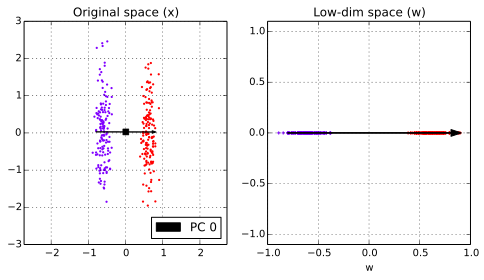

In [39]:
# example of LDA projection
ld = lda.LDA(n_components=1)
W  = ld.fit_transform(X, Y)

v = ld.coef_   # the basis vectors

plt.figure(figsize=(8,4))
plot_basis(X, v, Y=Y)

# On Iris data
- 4D to 2D
- LDA forms more compact classes
- With LDA, classes have less overlap if only using 1st basis vector.

In [40]:
# get data
X = iris.data
Y = iris.target

# run PCA
pca  = decomposition.PCA(n_components=2)
Wpca = pca.fit_transform(X)

# run LDA
ld   = lda.LDA(n_components=2)
Wld  = ld.fit_transform(X, Y)

ifig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(Wpca[:,0], Wpca[:,1], c=Y, cmap=rbow)
plt.axis('equal'); plt.grid(True)
plt.xlabel('PC1')
plt.ylabel('PC2');
plt.title("PCA")
plt.subplot(1,2,2)
plt.scatter(Wld[:,0], Wld[:,1], c=Y, cmap=rbow)
plt.axis('equal'); plt.grid(True)
plt.xlabel('v1')
plt.ylabel('v2')
plt.title("LDA")
plt.close()

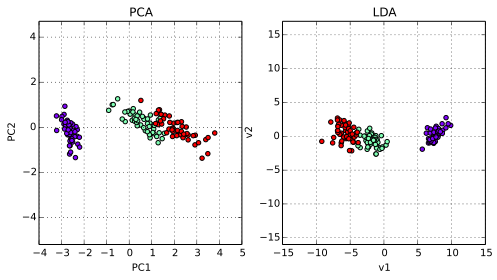

In [41]:
ifig

# Linear Dimensionality Reduction - Summary
- **Goal:** given set of input vectors $\{x_i\}_{i=1}^n$, with $x_i\in\mathbb{R}^d$, represent each input vector as lower-dimensional vector $w_i \in \mathbb{R}^p$.
  - Approximate $x$ as a weighted sum of basis vectors $v_j\in \mathbb{R}^d$
    - $\hat{x} = \sum_{j=1}^p w_j v_j$
    - minimize the reconstruction error of $\hat{x}$.
  - enables faster processing, or reduces noise.
  
<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Objective</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>Principal component analysis (PCA)</td>
<td>minimize reconstruction error; preserve the most variance of data</td>
<td>- captures correlated dimensions, removes redundant dimensions, removes noise.<br>- closed-form solution</td>
<td>- does not consider end goal (e.g., classification)</td>
</tr>
<tr>
<td>Latent Semantic Analysis (LSA)</td>
<td>minimize reconstruction error</td>
<td>- topic vectors have semantic meaning (co-occuring words)<br>- closed-form solution</td>
<td>- topic weights and topic vectors can be negative<br>- does not consider end goal (e.g., classification)</td>
</tr>
<tr>
<td>Non-negative Matrix Factorization (NMF)</td>
<td>minimize reconstruction error; non-negative weights and basis vectors.</td>
<td>- "additive" topic/parts model for text or images<br>- sparse topic weights.</td>
<td>- solution requires iterative algorithm.<br>- does not consider end goal (e.g., classification)</td>
</tr>
<tr>
<td>Linear Discriminant Analysis (LDA)</td>
<td>maximize class separation</td>
<td>- preserves class separation</td>
<td>- requires class information</td>
</tr>
</table>

# Other things
- _Feature Normalization_
  - PCA and LDA are based on the covariance between input dimensions.
  - applying _per-feature_ normalization will yield a different PCA result!
    - normalizing each input dimension changes the relative covariances.

In [42]:
X = iris.data[:,(2,1)]
Y = iris.target

# normalize the data
scaler = preprocessing.StandardScaler()
Xs = scaler.fit_transform(X)

# PCA on original
pca  = decomposition.PCA(n_components=1)
Wpca = pca.fit_transform(X)

# PCA on normalized
pca2  = decomposition.PCA(n_components=1)
Wpca2 = pca2.fit_transform(Xs)

nfig = plt.figure(figsize=(8,8))
plot_basis(X, pca.components_, sp=((2,2,1),(2,2,2)), Y=Y)
plot_basis(Xs, pca2.components_, sp=((2,2,3),(2,2,4)), Y=Y)
plt.subplot(2,2,3)
plt.title('Normalized space (x)')
plt.close()

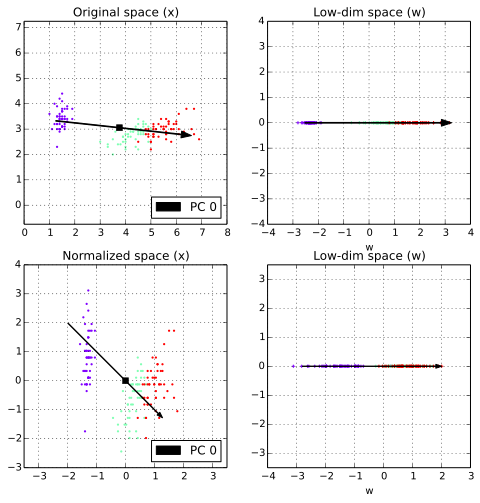

In [43]:
nfig